# CNN for rock-paper-scissors with Keras/TensorFlow

Date: February 24, 2019

Classification:
- rock
- paper
- scissors

## Preparing data set for CNN

In [79]:
DATA_FOLDER = '../python/data/'

FILES = 100
TRAINING_FILES = 70
TEST_FILES = FILES - TRAINING_FILES

In [80]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os

In [81]:
import glob

data_files = glob.glob(DATA_FOLDER+'*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            training_set.append((data/255, class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            test_set.append((data/255, class_number))
random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k))
    class_labels[v[2]] = k
    
import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

0: paper
1: rock
2: scissors


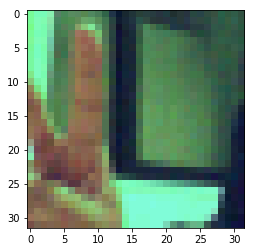

In [82]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data).reshape((TRAINING_FILES*len(class_labels), 32, 32, 3))
train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data).reshape((TEST_FILES*len(class_labels), 32, 32, 3))
test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(train_data[12,:,:,:])
#train_data[12,:,:,0]

### CNN model

In [105]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 64)          18496     
__________

In [106]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

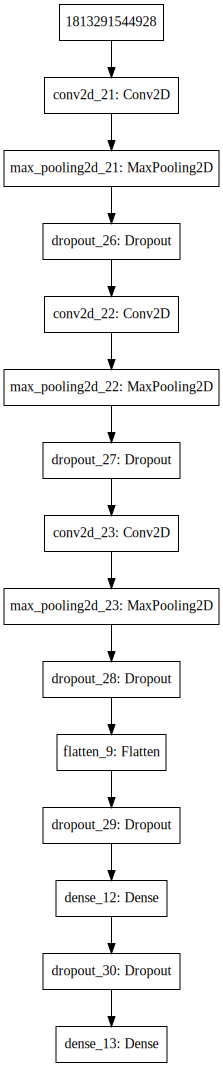

In [107]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [108]:
EPOCHS = 40
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 210 samples, validate on 90 samples
Epoch 1/40
210/210 [==============================] - 7s 32ms/step - loss: 1.5030 - acc: 0.3429 - val_loss: 1.0823 - val_acc: 0.4778
Epoch 2/40
210/210 [==============================] - 6s 31ms/step - loss: 1.0547 - acc: 0.4762 - val_loss: 1.0223 - val_acc: 0.4222
Epoch 3/40
210/210 [==============================] - 6s 28ms/step - loss: 0.9103 - acc: 0.5714 - val_loss: 0.9885 - val_acc: 0.4222
Epoch 4/40
210/210 [==============================] - 6s 29ms/step - loss: 0.9997 - acc: 0.4619 - val_loss: 1.0286 - val_acc: 0.4444
Epoch 5/40
210/210 [==============================] - 6s 29ms/step - loss: 0.8289 - acc: 0.5857 - val_loss: 1.0180 - val_acc: 0.4556
Epoch 6/40
210/210 [==============================] - 6s 29ms/step - loss: 0.7767 - acc: 0.6048 - val_loss: 0.8018 - val_acc: 0.6778
Epoch 7/40
210/210 [==============================] - 6s 29ms/step - loss: 0.7168 - acc: 0.6952 - val_loss: 0.9424 - val_acc: 0.5333
Epoch 8/40
210/210 [====

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


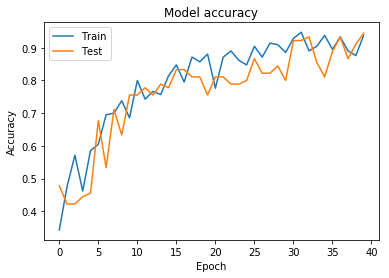

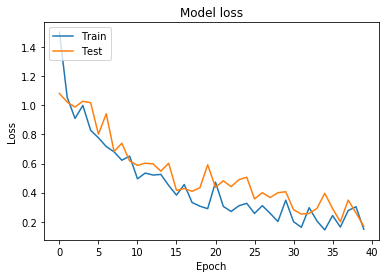

In [109]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [110]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'rock_paper_scissors_cnn_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [111]:
del model
model = models.load_model(filename)

## Confirmation

In [112]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(210, 32, 32, 3)

In [113]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [114]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [115]:
class_labels

['paper', 'rock', 'scissors']

In [116]:
(activations[-1][:10]*100).astype(int)

array([[14, 63, 22],
       [ 0,  0, 99],
       [ 0,  0, 99],
       [99,  0,  0],
       [ 0,  0, 99],
       [92,  6,  0],
       [ 0,  0, 99],
       [99,  0,  0],
       [ 0,  3, 96],
       [ 5, 93,  0]])

In [117]:
test_labels[:10].astype(int)

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [118]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(activations[layer][sample, :, :, i])
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'paper'

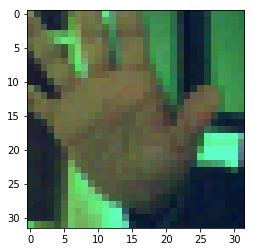

In [119]:
image_number = 10

plt.imshow(test_data[image_number,:,:,:])
class_labels[np.argmax(test_labels[image_number])]

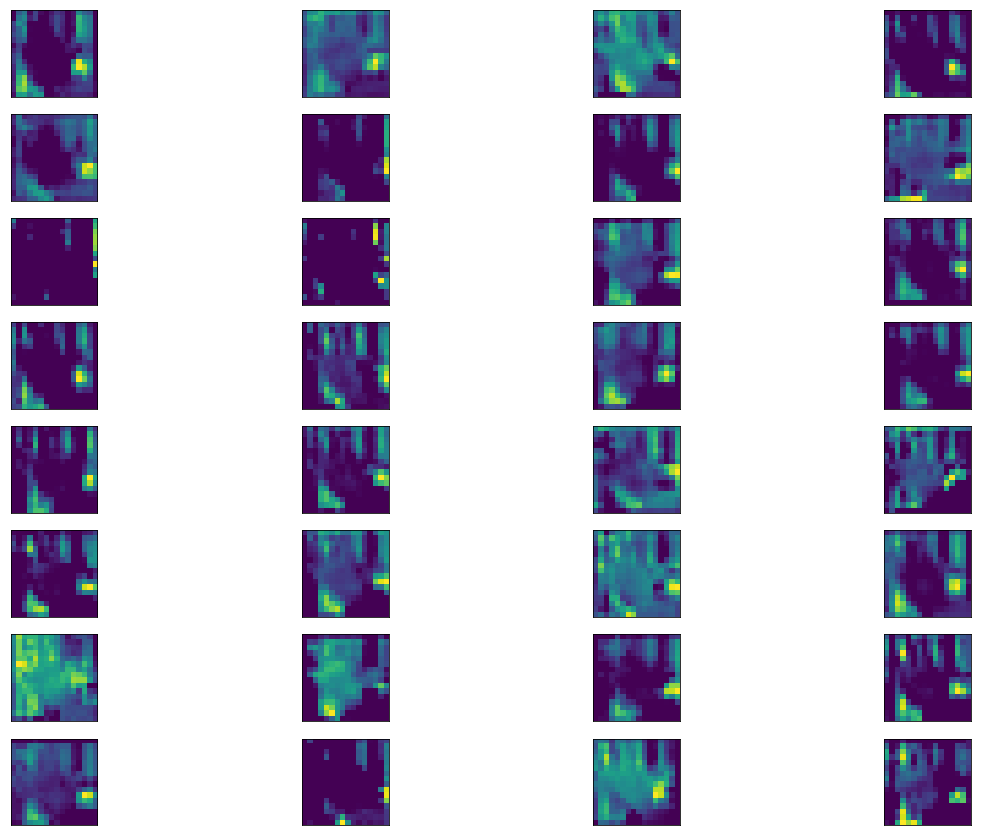

In [124]:
plot_layer(activations, image_number, 3)

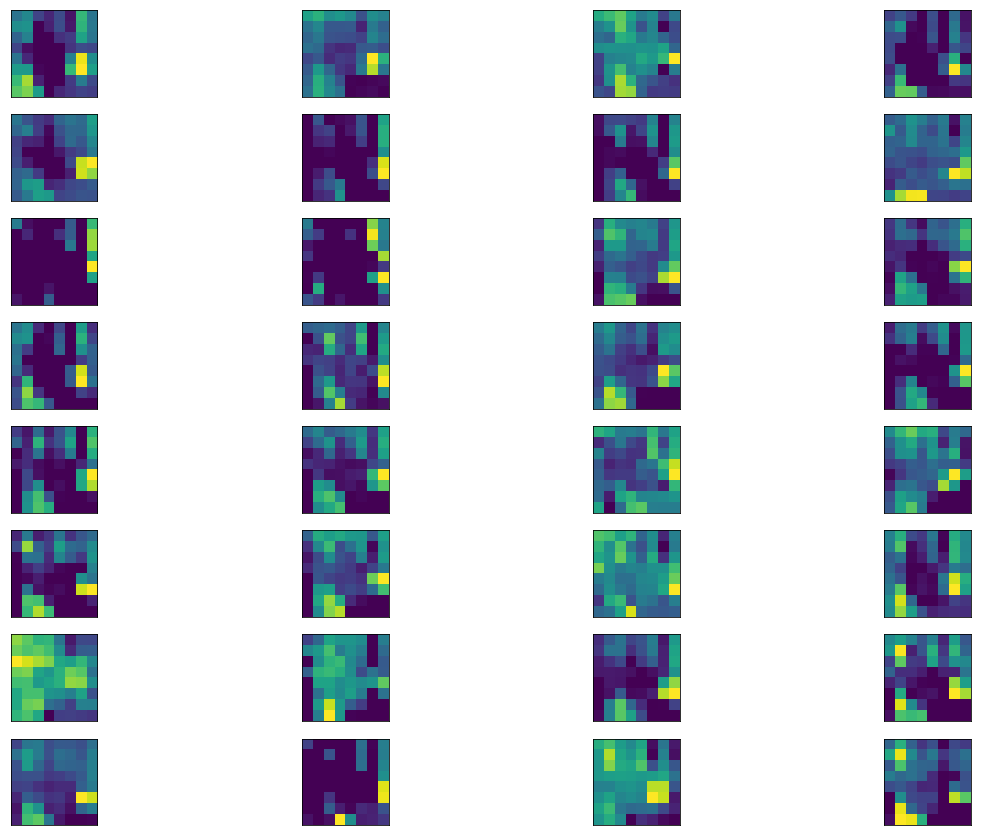

In [123]:
plot_layer(activations, image_number, 5)